In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import torch
import matplotlib.pyplot as plt
from estimators.data import TraversabilityDataset, get_transform
from estimators.data.TraversabilityDataset import PatchesDataset
from estimators.utils import get_learner
from utilities.postprocessing.utils import KrockPatchExtractStrategy
from utilities.patches import *
from interpretability import *
from utilities.patches import *
from jupyterthemes import jtplot
from estimators.utils import load_model_from_name
import matplotlib
import os


/home/francesco/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from jupyterthemes import jtplot
jtplot.reset()
#
plt.style.use(['science', 'ieee'])
# matplotlib.rcParams['figure.figsize'] = (5,4)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

# Parameters

In [4]:
model_name = 'microresnet#3-gate=7x7-n=1-se=True'
model_dir = '/media/francesco/Carino/vaevictis/data/1558825182.753924'
BASE_DIR = '/media/francesco/saetta/krock-dataset/test/'
TEST_META = BASE_DIR + '/meta.csv'

TEST_ROOT = '/media/francesco/saetta/krock-dataset/new-test-random/csvs_patches'
PATCHES_DIR = '/media/francesco/saetta/krock-dataset/new-test-random/patches/0.71/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
module = load_model_from_name(model_dir + '/roc_auc.pth', model_name )
module = module.eval().to(device)

MAX_ADVANCEMENT = 0.71
device

device(type='cuda')

# Analize Quarry Test Set
We are going to use the test set created from simulations run on the Quarry map to understand the model behaviour. We will try to answer different questions, such as "Which are the easiest traversable patches?" or "Are they any ground feature that can misslead the model?".

In [6]:
ds = TraversabilityDataset.from_root(TEST_ROOT, patches_dir=PATCHES_DIR, time_window = 50*2, patch_size=0.71, tr=0.2, transform=get_transform(debug=False))
learner, _ = get_learner(model_name, model_dir, [], dataset=ds)
explain = ExplainModel.from_leaner(learner, ds)

/home/francesco/Documents/Master-Thesis/core/interpretability/__init__.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, ds.df])


36128


In [7]:
explain.by_looking_at().tell(ClassificationAnswer.from_explain).plot_confusion_matrix()

SyntaxError: invalid syntax (<ipython-input-7-3c4f9d24ac59>, line 1)

## Visualize the best and worst patches sorted by advancement

In [24]:
'{:02d}'.format(2)

'02'

In [28]:
explanations = explain.by_looking_at([ Best(), Worst()],how_many=10, every=250)
base_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/quarry/all/'

for name, explanation in explanations.items():
        explanation.df = explanation.df.sort_values('advancement')
        print(explanation.df['advancement'])
        answers = explanation.tell(PatchAnswer.from_explain) 
        save_dir = '{}/{}'.format(base_dir, name)
        os.makedirs(save_dir, exist_ok=True)
        for i, answer in enumerate(answers):
            answer.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='{}/{:02d}-patch-3d-majavi-colormap-{}.png'.format(save_dir, int(explanation.df['advancement'].iloc[i] * 100), i), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)


0       0.351125
250     0.381787
776     0.443773
500     0.455441
1331    0.491537
1581    0.517617
2081    0.658459
1831    0.670353
2331    0.674230
1081    0.723328
Name: advancement, dtype: float64
8481    -0.083324
10414    0.001956
3471     0.014195
3721     0.015114
11046    0.021150
10796    0.035602
11969    0.060573
6070     0.062817
5783     0.101996
608      0.187742
Name: advancement, dtype: float64


## Most traversable patches
We expect the esiest traversable patches to be mostly flat. The following figure shows five patches sorted by the *traversable* class probability from the test set.

In [6]:
explanations = explain.by_looking_at([
                                      Shuffle(FalsePositive()),
                                      Shuffle(FalseNegative()),
                                      Shuffle(Worst()),
                                      Shuffle(Best()),
                                     ], how_many=5)

In [59]:
explanations['best'].tell(PatchAnswer.from_explain)[0].plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='/home/francesco/Desktop/diocane.png', azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)

In [61]:
import os
plt.style.use(['science', 'ieee'])
module = module.eval()
class MyExplanationsSaver():
    def __init__(self, base_dir):
        self.base_dir = base_dir
            
    def __call__(self, explanations):
        for name, explanation in explanations.items():
            answers = explanation.tell(PatchAnswer.from_explain)
            save_dir = '{}/{}'.format(self.base_dir, name)
            os.makedirs(save_dir, exist_ok=True)
            print(answers)
            for i, answer in enumerate(answers):
                answer.plot2d().savefig('{}/patch-2d-{}'|.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.grad_cam(module.eval(), device, target_class=0).plot2d().savefig('{}/grad-cam-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.heatmap((8,8)).plot2d().savefig('{}/heatmap-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d(title='', rstride=1, cstride=1,)[0].savefig('{}/patch-3d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path='{}/patch-3d-majavi-colormap-{}.png'.format(save_dir,i), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)
                plt.close("all")
                
MyExplanationsSaver('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/quarry/')(explanations)

[Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78)]
[Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78)]
[Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78)]
[Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78), Shape = (78, 78)]


In [ ]:
def plot_answer(answer):
    answer.plot2d()
    answer.grad_cam(module, device).plot2d()
    answer.heatmap((8,8)).plot2d()
#     _ = answer.plot3d()[0]

Clearly, most of the patches are flat. The first patch is entirery flat, looking at the heights we can see that every value is zero. Interesting, the grad cam thinks highlights the middle of the patch. Grad cam creates a circle in the middle where the maximum activation point is exactly at the Krock's head position, 36 pixels from the left. Interesting, the highligthed region corespond to the Krock position while walking in flat ground. Correctly the full Krock footprint is highligthed while the corners are not taken into account since the robot won't ever reach them. So, our model is looking at the head position, at the robot footprint and at the future possible reachable region.

In [ ]:
answers = explanations['best'].tell(PatchAnswer.from_explain)

plot_answer(answers[0])

In [ ]:
for answers in explanations.values():
    for answer in answers:
        answers[idx].plot2d()
        answers[idx].grad_cam(module, device).plot2d()
        answers[idx].heatmap((8,8)).plot2d()
        _ = answers[idx].plot3d()[0]
# answers[idx].add_advancement_using_simulator(3, 100).plot2d()

In [ ]:
Patch.plot_all_2d(answers)

In [ ]:
import gc

gc.collect()

# Custom Patches


We can test the robustness of the model by creating custom patches with trivial geometric shapes, walls/bumps, and test the model by comparing its prediction to the real robot in the simulator.

In [10]:
def get_answers_from_patches(patches):
    walls_ds = PatchesDataset(patches=patches, transform=get_transform())
    learner, _ = get_learner(model_name, model_dir, [], dataset=walls_ds)
    explain = ExplainModel.from_leaner(learner, walls_ds)
    answer = explain.tell(answer=CustomPatchAnswer.from_explain)
    return answer, explain

In [11]:
def store_figures(figures, out_path):
    for i, fig in enumerate(figures):
        fig[0].savefig('{}{}.png'.format(out_path,i), bbox_inches='tight', transparent=True)
        
def save2d_and_2d(p, out_dir, n):
    p.plot2d().savefig(out_dir + '/{}-2d.png'.format(n))
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/{}-3d.png'.format(n), azimuth=0, elevation=35, mesh=True, colormap='viridis', vmax=1)

## Walls at different positions in front of Krock
The most trival way to correctly test the model is to place different walls in front of krock at an increasing distance. The wall is 1 meter high, so it is not traversable, but we had a treshold of 20cm, meaning that, even if the wall is not traversable, when it is at more than 20cm from krock on flat ground the model should yield true. We are going to test the model with different patches starting with a wall placed exactly in front of the robot, then we will move the wall one cm at the time till the end of the patch.

In [12]:
out_dir = '/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/custom_patches/walls_front'

In [13]:
patch_shape = KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT)

res = 0.02
krock_body = 0.85 // res
surely_in_front_of_krock = int(krock_body + 8) # the head is at 14cm (7px) from the krock's pose

steps = np.arange(1, patch_shape[0] - surely_in_front_of_krock)
offsets = steps + surely_in_front_of_krock
offsets = patch_shape[1] - offsets # offset are defined from the rigth side
offsets = np.linspace(offsets[-1], offsets[0], len(offsets) * 2)

offsets

array([ 1.      ,  1.490909,  1.981818,  2.472727, ..., 26.527273, 27.018182, 27.509091, 28.      ])

In [14]:
walls = [WallPatch(KrockPatchExtractStrategy.patch_shape(0.66), strength=1, back=False, offset=int(offset))() for offset in offsets]

answer, explanation = get_answers_from_patches(walls)

56


In [15]:
explanation.df['distance'] = (((patch_shape[1] - offsets) - surely_in_front_of_krock) - walls[0].size // 2) * res * 100# convert back to cm and to 'in front of krock coordinates'

# explanation.df = explanation.df[::-1]
explanation.df.to_csv(out_dir + 'walls_front.csv')
explanation.df

,out_0,out_1,prediction,distance
0,0.000443,0.999557,1,52.000000
1,0.000443,0.999557,1,51.018182
2,0.000443,0.999557,1,50.036364
3,0.000000,1.000000,1,49.054545
4,0.000000,1.000000,1,48.072727
5,0.000000,1.000000,1,47.090909
6,0.000000,1.000000,1,46.109091
7,0.000000,1.000000,1,45.127273
8,0.000000,1.000000,1,44.145455
9,0.000000,1.000000,1,43.163636


We can say that the model classifies all the wall between 0cm to 19cm from krock's head as no traversable and the ones more than 20cm far away traversable, as expected. Let's use the simulator to get the real advancement of the robot on this ground. We will test the last non traversable and the first traversable

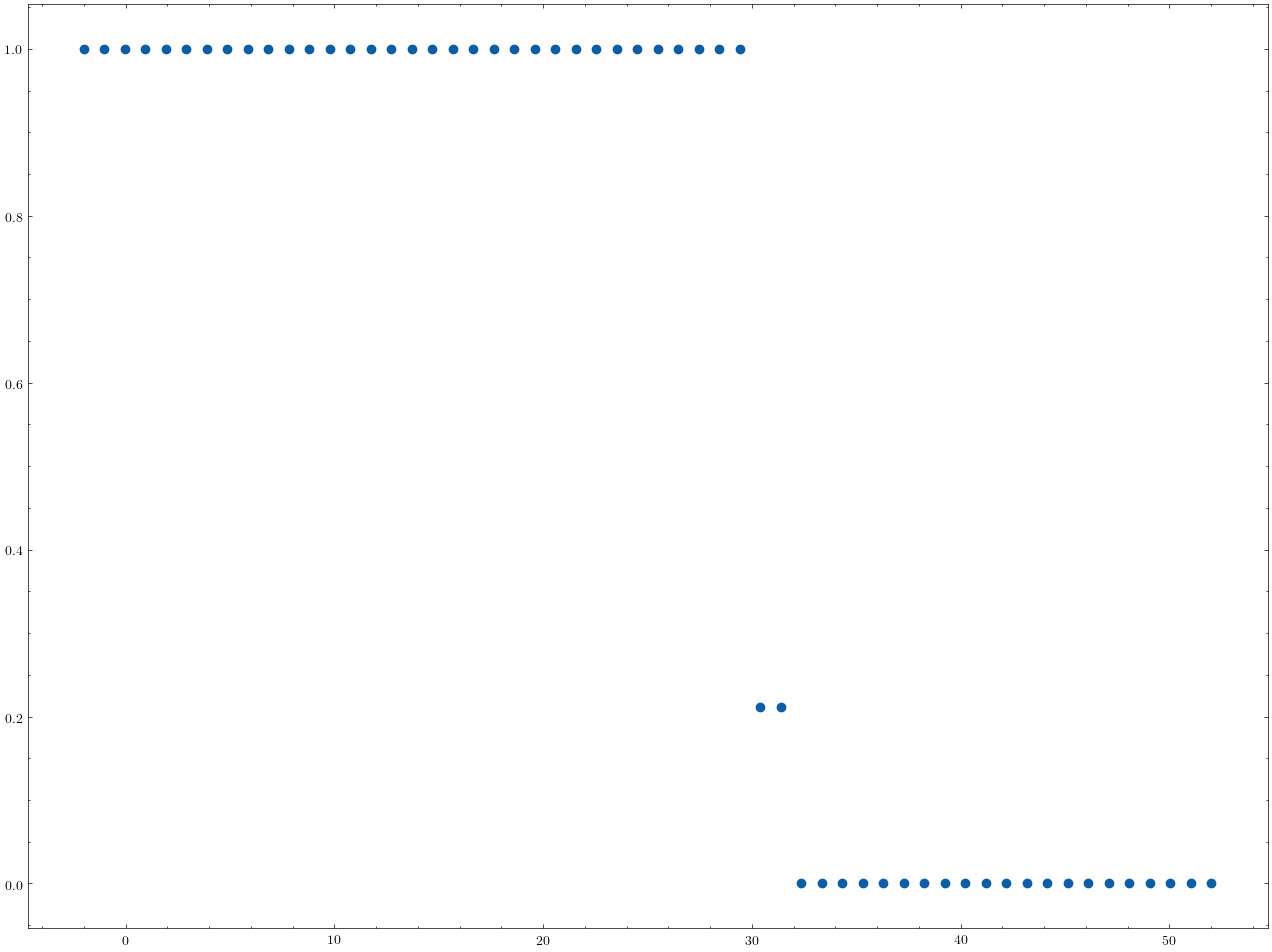

In [73]:

plt.style.use(['science'])
matplotlib.rcParams['figure.figsize'] = (16,12)
fig = plt.figure()
# explanation.df = explanation.df.reset_index(drop=True)
# explanation.df = explanation.df.iloc[::-1]
# explanation.df['out_0'].plot(label='not traversable').legend()
# explanation.df['out_1'].plot(label='traversable').legend()

plt.scatter(explanation.df['distance'].values, explanation.df['out_1'].values)
plt.show()
fig.savefig(out_dir + '/predictions.png')


In [ ]:
seconds = 3
time_window = 100
answer[33].add_advancement_using_simulator(seconds, time_window)
answer[32].add_advancement_using_simulator(seconds, time_window)

In [18]:
# store all the walls for the thesis
for n, p in enumerate(answer[0:2]):
    p.plot3d_mayavi(0.02, size=(513,513), distance=3.5, save_path=out_dir + '/all/{:02d}-3d.png'.format(n), azimuth=0, color=(0,0.5,0), elevation=35, mesh=True, vmax=1)

In [254]:
save2d_and_2d(answer[33], out_dir, 1)
save2d_and_2d(answer[32], out_dir, 2)

Correctly the advancement in the last traversable is slighty less than 20cm and the one in the first no traversable is more than 20cm. 

## Walls in front of krock of different height

What is the minimum height for a wall in front of Krock to be traversable? We can asnwer to this question by creating 10 walls from 1cm to 20cm and place them in front of the robot and the comparing the model's output with the advancement getted from the simulator.

In [18]:
walls = [WallPatch(KrockPatchExtractStrategy.patch_shape(0.71), strength=s, back=False, offset=offset)() for s in np.linspace(0.01, 0.2, 20)]
walls_ds = PatchesDataset(patches=walls, transform=get_transform())

NameError: name 'offset' is not defined

In [48]:
learner, _ = get_learner(model_name, model_dir, [], dataset=walls_ds)
learner.model = learner.model.eval()
explain = ExplainModel.from_leaner(learner, walls_ds)

100


In [49]:
%matplotlib notebook

In [50]:
explain.df['prediction']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
90    0
91    0
92    0
93    0
94    0
95    0
96    0
97    0
98    0
99    0
Name: prediction, Length: 100, dtype: int64

In [4]:
answer = explain.tell(answer=PatchAnswer.from_explain)

answer[9].plot3d()

# answer[8].grad_cam(module, device).plot2d()
# answer[9].add_advancement_using_simulator(2, 100)

# answer[9].df['advancement'].plot()
answer[10].grad_cam(module, device, target_class=1).plot2d()

NameError: name 'explain' is not defined

## Bumps

## Ramps